# Import

In [1]:
import pickle

from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import pipeline
import torch
import pandas as pd
import emoji
import re
from os.path import exists
import dataframe_image as dfi

from torch.utils.data import DataLoader,SequentialSampler,TensorDataset
import pandas_ta as ta
import time
import numpy as np

import spacy
import nltk
from nltk.corpus import stopwords
from sentence_transformers import *

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from scipy.cluster import hierarchy as sch

from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

[nltk_data] Downloading package stopwords to /home/andrei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_pickle('Datasets/market/market_sentiment.pkl')

In [3]:
apple = data[data.Ticker=='AAPL']

In [4]:
apple['ewm'] = apple.sentiment.ewm(14).mean()

In [5]:
apple['ema'] = ta.ema(apple["sentiment"], length=14)

In [6]:
apple

component,Date,Adj Close,Close,High,Low,Open,Volume,holidays,Ticker,sentiment,ewm,ema
0,2015-01-02,24.603209,27.332500,27.860001,26.837500,27.847500,212818400.0,0.0,AAPL,0.451456,0.451456,NaN
6,2015-01-05,23.910091,26.562500,27.162500,26.352501,27.072500,257142000.0,0.0,AAPL,0.444978,0.448105,NaN
12,2015-01-06,23.912342,26.565001,26.857500,26.157499,26.635000,263188400.0,0.0,AAPL,0.41693,0.436989,NaN
18,2015-01-07,24.247650,26.937500,27.049999,26.674999,26.799999,160423600.0,0.0,AAPL,0.394427,0.425223,NaN
24,2015-01-08,25.179296,27.972500,28.037500,27.174999,27.307501,237458000.0,0.0,AAPL,0.367257,0.411978,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7788,2019-12-25,69.623230,71.067497,71.222504,70.730003,71.172501,48478800.0,1.0,AAPL,0.377232,0.389381,0.389013
7794,2019-12-26,71.004585,72.477501,72.495003,71.175003,71.205002,93121200.0,0.0,AAPL,0.375746,0.388472,0.387244
7800,2019-12-27,70.977631,72.449997,73.492500,72.029999,72.779999,146266000.0,0.0,AAPL,0.402397,0.389400,0.389264
7806,2019-12-30,71.398888,72.879997,73.172501,71.305000,72.364998,144114400.0,0.0,AAPL,0.398724,0.390022,0.390526


<AxesSubplot: >

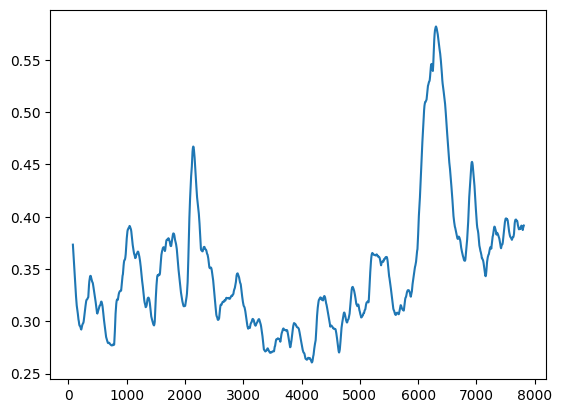

In [7]:
apple.ema.plot()

<AxesSubplot: >

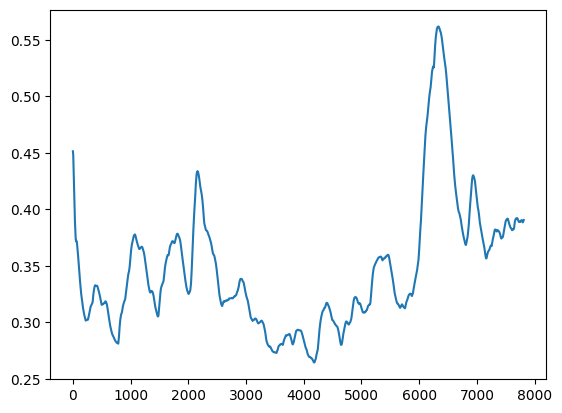

In [8]:
apple['ewm'].plot()

# Load tweets

In [9]:
tweets_path = "Datasets/kaggle/Tweet.csv"
id_to_ticker_path = "Datasets/kaggle/Company_Tweet.csv"
ticker_to_name_path = "Datasets/kaggle/Company.csv"

In [10]:
def init_datasets():
    tweets_df = pd.read_csv(tweets_path)
    tickers_df = pd.read_csv(id_to_ticker_path)
    company_name_df = pd.read_csv(ticker_to_name_path)

    tweets_df.post_date = pd.to_datetime(tweets_df.post_date, unit='s', origin='unix') # Converting to datetime

    single_stock = tickers_df.tweet_id.value_counts()
    single_stock = pd.Series(single_stock[single_stock == 1].index)

    return tweets_df, single_stock, tickers_df

In [11]:
tweets_df, single_stock, tickers_df = init_datasets()

In [12]:
if exists("Datasets/results/preprocessing/final.pkl"):
    tickers_df = pd.read_pickle("Datasets/results/preprocessing/tickers_df.pkl")
    pass
elif exists("Datasets/results/preprocessing/tweets_df.pkl") and exists("Datasets/results/preprocessing/single_stock.pkl"):
    tweets_df = pd.read_pickle("Datasets/results/preprocessing/tweets_df.pkl")
    single_stock = pd.read_pickle("Datasets/results/preprocessing/single_stock.pkl")
else:
    tweets_df, single_stock, tickers_df = init_datasets()
    tweets_df.to_pickle("Datasets/results/preprocessing/tweets_df.pkl")
    single_stock.to_pickle("Datasets/results/preprocessing/single_stock.pkl")
    tickers_df.to_pickle("Datasets/results/preprocessing/tickers_df.pkl")

# Preprocessing

### Remove tweets with more than 1 stock

In [13]:
if exists("Datasets/results/preprocessing/final.pkl") or exists("Datasets/results/preprocessing/preprocessed.pkl"):
    print("421101 tweets were removed - 11.33 %")
else:
    clean_tweets = tweets_df[tweets_df.tweet_id.isin(single_stock)].reset_index(drop=True)
    print(f"{tweets_df.shape[0] - clean_tweets.shape[0]} tweets were removed \
    - {((1 - (clean_tweets.shape[0] / tweets_df.shape[0])) * 100):.2f} %")

421101 tweets were removed - 11.33 %


### Remove intraday duplicates by complete matches

In [14]:
if exists("Datasets/results/preprocessing/final.pkl") or exists("Datasets/results/preprocessing/preprocessed.pkl"):
    print("160160 tweets were removed - 4.86 %")
else:
    a = clean_tweets.shape[0]
    clean_tweets = clean_tweets.assign(day=clean_tweets['post_date'].dt.date).drop_duplicates(subset=(['day', 'body'])).drop('day',axis=1).reset_index(drop=True)
    b = clean_tweets.shape[0]
    print(f"{a-b} tweets were removed - {((1 - (a/b))*100):.2f} %")

160160 tweets were removed - 4.86 %


### Text clean

In [15]:
def clean_text(x):
    x = re.sub(r'http[s]?://\S+', ' ', x) # remove links (caused problems so had to move here)
    x = re.sub(r'[?<=^|\s](\w*-?\w+\.[a-z]{2,}\S*)', ' ', x) # remove links
    x = re.sub(r'\$[A-Za-z]+', ' ', x) # remove tickers
    x = re.sub(r'\@[A-Za-z]+', ' ', x) # remove mentions
    x = x.lower() # lowercase everything
    x = x.encode('ascii', 'ignore').decode()  # remove unicode characters
    # cleaning up text
    x = re.sub(r'\d', ' ', x)
    x = re.sub(r'["“”\*+-/:;<=>\\^_`{|}~]', ' ', x) # remove useless punctuation
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)
    return x.strip()

In [16]:
if not exists("Datasets/results/preprocessing/final.pkl") and not exists("Datasets/results/preprocessing/preprocessed.pkl"):
    clean_tweets['preprocessed'] = clean_tweets.body.apply(lambda tweet: clean_text(tweet))

### Remove intraday duplicates after preprocessing

In [17]:
if exists("Datasets/results/preprocessing/final.pkl") or exists("Datasets/results/preprocessing/preprocessed.pkl"):
    print("359478 tweets were removed")
else:
    a = clean_tweets.shape[0]
    clean_tweets = clean_tweets.assign(day=clean_tweets['post_date'].dt.date).drop_duplicates(subset=(['day', 'preprocessed'])).drop('day',axis=1).reset_index(drop=True)
    b = clean_tweets.shape[0]
    print(f"{a-b} tweets were removed")

359478 tweets were removed


### Combine tweet interactions into 1 feature

In [18]:
if not exists("Datasets/results/preprocessing/final.pkl") and not exists("Datasets/results/preprocessing/preprocessed.pkl"):
    clean_tweets['interactions'] = clean_tweets.comment_num + clean_tweets.retweet_num + clean_tweets.like_num
    clean_tweets.drop(clean_tweets.filter(["comment_num", "retweet_num", "like_num", "writer"]), inplace=True, axis=1)
    clean_tweets.to_pickle("Datasets/results/preprocessing/preprocessed.pkl")

# Sentiment analysis

In [19]:
tokenizer_sentiment = RobertaTokenizer.from_pretrained('zhayunduo/roberta-base-stocktwits-finetuned')
model_sentiment = RobertaForSequenceClassification.from_pretrained('zhayunduo/roberta-base-stocktwits-finetuned')

In [20]:
def batch_checkSenti(texts,model=model_sentiment,tokenizer=tokenizer_sentiment,return_logits=False):
  start = time.time()
  input_ids = []
  attention_masks = []
  for text in texts:
      encoded_data = tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      truncation=True,
      max_length=64,
      padding='max_length',
      return_attention_mask= True,
      return_tensors='pt'
      )

      input_ids.append(encoded_data['input_ids'])
      attention_masks.append(encoded_data['attention_mask'])

  input_ids = torch.cat(input_ids,dim=0)
  attention_masks = torch.cat(attention_masks,dim=0)

  model.to(device)
  
  print(f'It takes {time.time() - start}s to tokenize')
  checkpointtime = time.time()

  testset = TensorDataset(input_ids,attention_masks)
  test_dl = DataLoader(testset,sampler = SequentialSampler(testset),batch_size = 128)

  predictions = []
  for batch in test_dl:
      batch = tuple(b.to(device) for b in batch)
      inputs = {
          'input_ids':batch[0],
          'attention_mask': batch[1],
      }

      with torch.no_grad():
          outputs = model(**inputs)

      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      predictions.append(logits)

  predictions = np.concatenate(predictions,axis=0)
  index = predictions.argmax(axis=1)
  print(f'It takes {time.time() - checkpointtime}s to do predictions')

  return (index, predictions) if return_logits else index

In [21]:
if exists("Datasets/results/preprocessing/final.pkl"):
    pass
elif  exists("Datasets/results/preprocessing/sentiment_finetuned.pkl"):
    clean_tweets = pd.read_pickle("Datasets/results/preprocessing/sentiment_finetuned.pkl")
else:
    clean_tweets = pd.read_pickle("Datasets/results/preprocessing/preprocessed.pkl")
    clean_tweets_sentiment = batch_checkSenti(clean_tweets.preprocessed)
    clean_tweets = clean_tweets.join(
        pd.Series(clean_tweets_sentiment, name='sentiment_score')
        )
    clean_tweets.to_pickle("Datasets/results/preprocessing/sentiment_finetuned.pkl")

### Compare Sentiment finetuned with FinBert

In [22]:
def comparison():
    clean_tweets_old = pd.read_pickle("Datasets/results/preprocessing/tweets_total.pkl")
    compare = pd.merge(clean_tweets_old, clean_tweets[['tweet_id', 'sentiment_score']], on='tweet_id', how='left')
    diff = compare[(compare.label=='Positive') & (compare.sentiment_score == 0)]
    return diff

In [23]:
# diff = comparison()
# diff[100:120]

In [24]:
# diff.loc[6284].body

# Lemmatization

In [25]:
def lemmatize_pipe(doc):
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in stopwords] 
    return lemma_list

def preprocess_pipe(texts):
    preproc_pipe = [lemmatize_pipe(doc) for doc in nlp.pipe(texts, batch_size=512, n_process=-1)]
    return preproc_pipe

In [27]:
if exists("Datasets/results/preprocessing/final.pkl"):
    clean_tweets = pd.read_pickle("Datasets/results/preprocessing/final.pkl")
else:
    clean_tweets['preprocessed'] = clean_tweets['preprocessed'].str.replace('[^ \w+]', '')
    nlp = spacy.load("en_core_web_sm")
    clean_tweets['lemmatized'] = preprocess_pipe(clean_tweets['preprocessed'])
    clean_tweets['cleaned'] = clean_tweets.lemmatized.apply(lambda x: ' '.join(x))
    clean_tweets = clean_tweets.drop_duplicates(subset=['cleaned']).reset_index(drop=True)
    clean_tweets.to_pickle("Datasets/results/preprocessing/final.pkl")

In [28]:
clean_tweets

,tweet_id,post_date,body,preprocessed,interactions,sentiment_score,lemmatized,cleaned
0,550441509175443456,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",lx madeon check it out learn howtotrade,1,0,"[lx, madeon, check, learn, howtotrade]",lx madeon check learn howtotrade
1,550441672312512512,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,insanity of today weirdo massive selling bid u...,0,0,"[insanity, today, weirdo, massive, selling, bi...",insanity today weirdo massive selling bid cent...
2,550441732014223360,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,sp stocks performance more,0,1,"[sp, stock, performance]",sp stock performance
3,550442977802207232,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,volkswagen pushes record recall tally higher,1,0,"[volkswagen, pushes, record, recall, tally, high]",volkswagen pushes record recall tally high
4,550444969924653056,2015-01-01 00:14:42,$AAPL Apple goes global with 'Start Something ...,apple goes global with start something new ad ...,1,1,"[apple, go, global, start, something, new, ad,...",apple go global start something new ad campaign
...,...,...,...,...,...,...,...,...
2360616,1212159254884433921,2019-12-31 23:51:01,Imagine calling your broker-dealer and wanting...,imagine calling your broker dealer and wanting...,2,1,"[imagine, call, broker, dealer, want, buy, goo...",imagine call broker dealer want buy good chunk...
2360617,1212159275637886976,2019-12-31 23:51:06,"$AAPL yearly~ Heck of a year.. Jan. 2, 1999~ar...",yearly heck of a year jan around bucks lolhave...,1,1,"[yearly, heck, year, jan, around, buck, lolhav...",yearly heck year jan around buck lolhave frien...
2360618,1212159765914079234,2019-12-31 23:53:03,That $SPY $SPX puuump in the last hour was the...,that puuump in the last hour was the eoy eoq e...,7,1,"[puuump, last, hour, eoy, eoq, eom, top, windo...",puuump last hour eoy eoq eom top window dressi...
2360619,1212159838882533376,2019-12-31 23:53:21,In 2020 I may start Tweeting out positive news...,in i may start tweeting out positive news abou...,1,0,"[may, start, tweet, positive, news, every, neg...",may start tweet positive news every negative t...


### bert-large-nli-mean-tokens

In [ ]:
# model_sentence = SentenceTransformer('bert-large-nli-mean-tokens')

In [ ]:
# if exists("Datasets/results/preprocessing/embeddings.pkl"):
#     with open('Datasets/results/preprocessing/embeddings.pkl', "rb") as file:
#         embedding = pickle.load(file)
# else:
#     embeddings = model_sentence.encode(clean_tweets['cleaned'])
    
#     with open('Datasets/results/preprocessing/embeddings.pkl', "wb") as file:
#         pickle.dump(embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)

#     with open('Datasets/results/preprocessing/embeddings_raw.pkl', "wb") as file:
#         pickle.dump(clean_tweets['cleaned'], file, protocol=pickle.HIGHEST_PROTOCOL)

### MiniLM-L6-v2

In [ ]:
model_sentence_2 = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
if exists("Datasets/results/preprocessing/embeddings_2.pkl"):
    with open('Datasets/results/preprocessing/embeddings_2.pkl', "rb") as file:
        embeddings = pickle.load(file)
else:
    embeddings = model_sentence_2.encode(clean_tweets['cleaned'])
    
    with open('Datasets/results/preprocessing/embeddings_2.pkl', "wb") as file:
        pickle.dump(embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)

    with open('Datasets/results/preprocessing/embeddings_raw.pkl', "wb") as file:
        pickle.dump(clean_tweets['cleaned'], file, protocol=pickle.HIGHEST_PROTOCOL)

# Clustering

In [ ]:
if exists("Datasets/results/preprocessing/appl_tweets.pkl"):
    tweets = pd.read_pickle("Datasets/results/preprocessing/appl_tweets.pkl")
    print("Downloaded")
else:
    ids = tickers_df[tickers_df.ticker_symbol == 'AAPL'].tweet_id
    tweets = clean_tweets[clean_tweets.tweet_id.isin(ids)]
    tweets.to_pickle("Datasets/results/preprocessing/appl_tweets.pkl")

In [ ]:
if exists("Datasets/results/preprocessing/msft_tweets.pkl"):
    tweets = pd.read_pickle("Datasets/results/preprocessing/msft_tweets.pkl")
    print("Downloaded")
else:
    ids = tickers_df[tickers_df.ticker_symbol == 'MSFT'].tweet_id
    tweets = clean_tweets[clean_tweets.tweet_id.isin(ids)]
    tweets.to_pickle("Datasets/results/preprocessing/msft_tweets.pkl")

In [ ]:
if exists("Datasets/results/preprocessing/tsla_tweets.pkl"):
    tweets = pd.read_pickle("Datasets/results/preprocessing/tsla_tweets.pkl")
    print("Downloaded")
else:
    ids = tickers_df[tickers_df.ticker_symbol == 'TSLA'].tweet_id
    tweets = clean_tweets[clean_tweets.tweet_id.isin(ids)]
    tweets.to_pickle("Datasets/results/preprocessing/tsla_tweets.pkl")

In [ ]:
if exists("Datasets/results/preprocessing/amzn_tweets.pkl"):
    tweets = pd.read_pickle("Datasets/results/preprocessing/amzn_tweets.pkl")
    print("Downloaded")
else:
    ids = tickers_df[tickers_df.ticker_symbol == 'AMZN'].tweet_id
    tweets = clean_tweets[clean_tweets.tweet_id.isin(ids)]
    tweets.to_pickle("Datasets/results/preprocessing/amzn_tweets.pkl")

In [ ]:
if exists("Datasets/results/preprocessing/google_tweets.pkl"):
    tweets = pd.read_pickle("Datasets/results/preprocessing/google_tweets.pkl")
    print("Downloaded")
else:
    ids = tickers_df[(tickers_df.ticker_symbol == 'GOOG') | (tickers_df.ticker_symbol == 'GOOGL')].tweet_id
    tweets = clean_tweets[clean_tweets.tweet_id.isin(ids)]
    tweets.to_pickle("Datasets/results/preprocessing/google_tweets.pkl")

In [ ]:
len(tweets)

In [ ]:
seed_topic_list = [
    ["buy", "sell", "long", "short", "trade", "chart"],
    ["report", "quarter", "dividend", "annual", "revenue"],
    ["read", "via", "article"],
    ["management", "sale", "goal"]
    ]

# hdbscan_model = HDBSCAN(min_cluster_size=900, metric='euclidean', cluster_selection_method='eom')
# topic_model = BERTopic(hdbscan_model=hdbscan_model, language='English', verbose=True, seed_topic_list=seed_topic_list)

# umap_model = UMAP(n_neighbors=4, n_components=5, metric='cosine', low_memory=False)
umap_model = UMAP(n_neighbors=4, n_components=5, metric='cosine', low_memory=True)
hdbscan_model = HDBSCAN(min_cluster_size=1000, metric='euclidean', prediction_data=False)

topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    seed_topic_list=seed_topic_list,
    language="english",
    top_n_words=10,
    # min_topic_size=500,
    low_memory=True,
    calculate_probabilities=False,
    nr_topics="auto",
    verbose=True,
    # n_gram_range=(1, 2)
    )

In [ ]:
with open('Datasets/results/preprocessing/embeddings_2.pkl', "rb") as file:
    embeddings = pickle.load(file)

with open('Datasets/results/preprocessing/embeddings_raw.pkl', "rb") as file:
    embeddings_raw = pickle.load(file)

In [ ]:
raw = embeddings_raw.iloc[tweets.index.tolist()].reset_index(drop=True)
emb = embeddings[tweets.index.tolist()]

In [ ]:
# topics, probs = topic_model.fit_transform(raw, emb)

In [ ]:
topic_model_google = BERTopic.load("topics/google_model")

In [ ]:
topic_model_google.get_topic_info()

In [ ]:
topic_model_google.visualize_topics()

In [ ]:
topic_model_google.visualize_barchart()

In [ ]:
topic_model_google.get_topic(0)

In [ ]:
topic_model_google.get_representative_docs(0)

In [ ]:
topic_model_google.visualize_hierarchy()

In [ ]:
topic_model_google.get_topic(3)

In [ ]:
topic_model_google.get_topic_info()

In [ ]:
# topic_model_google.transform(raw[150:160], emb[150:160])

In [ ]:
# topic_model.reduce_topics(embeddings_raw.iloc[tweets.index.tolist()].reset_index(drop=True), nr_topics=30)

In [ ]:
# topic_model.visualize_hierarchy()


In [ ]:
# topic_model.get_topic_info()